Linear trend (AIR_TEMPERATURE vs time):
  slope = 0.001178 degC/day
  intercept = 8.7834 degC

Descriptive stats for AIR_TEMPERATURE (degC):
count    630854.000000
mean         10.074197
std           7.820270
min         -12.100000
25%           4.400000
50%          10.100000
75%          16.300000
max          29.900000
Name: AIR_TEMPERATURE, dtype: float64


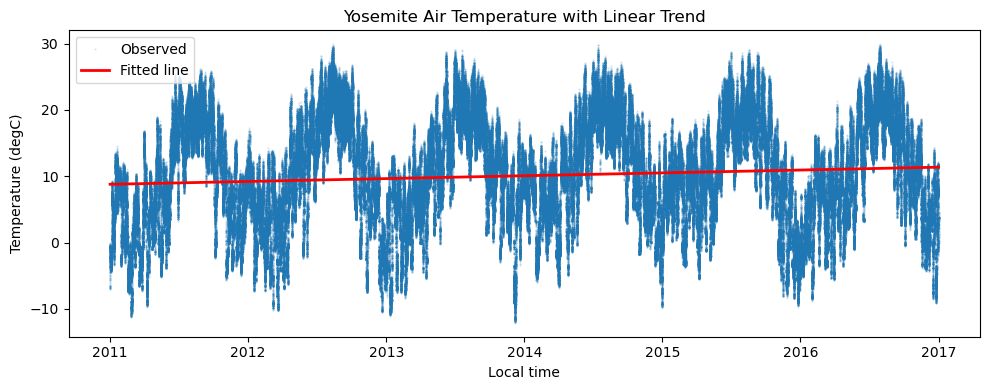

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Column names from the dataset README
cols = [
    "WBANNO", "UTC_DATE", "UTC_TIME", "LST_DATE", "LST_TIME", "CRX_VN",
    "LONGITUDE", "LATITUDE", "AIR_TEMPERATURE", "PRECIPITATION", "SOLAR_RADIATION",
    "SR_FLAG", "SURFACE_TEMPERATURE", "ST_TYPE", "ST_FLAG", "RELATIVE_HUMIDITY",
    "RH_FLAG", "SOIL_MOISTURE_5", "SOIL_TEMPERATURE_5", "WETNESS", "WET_FLAG",
    "WIND_1_5", "WIND_FLAG"
]

# Load all yearly Yosemite files and combine
files = sorted(Path("yosemite-temperatures/yosemite_village").glob("*.txt"))
df = pd.concat(
    [pd.read_csv(f, sep=r"\s+", names=cols, header=None) for f in files],
    ignore_index=True,
)

# Convert local date/time into a datetime index
lst_time = df["LST_TIME"].astype(str).str.zfill(4)
df["LST_DATETIME"] = pd.to_datetime(
    df["LST_DATE"].astype(str) + lst_time,
    format="%Y%m%d%H%M",
    errors="coerce",
)

# Replace sentinel missing values with NaN for analysis
missing_map = {
    "AIR_TEMPERATURE": -9999.0,
    "PRECIPITATION": -9999.0,
    "SOLAR_RADIATION": -99999,
    "SURFACE_TEMPERATURE": -9999.0,
    "RELATIVE_HUMIDITY": -9999,
    "SOIL_MOISTURE_5": -99.000,
    "SOIL_TEMPERATURE_5": -9999.0,
    "WIND_1_5": -99.00,
}
for c, mv in missing_map.items():
    df.loc[df[c] == mv, c] = np.nan

# Keep rows with valid time + temperature
temp_df = df[["LST_DATETIME", "AIR_TEMPERATURE"]].dropna().sort_values("LST_DATETIME")

# Fit straight line: temperature vs time
x_days = (temp_df["LST_DATETIME"] - temp_df["LST_DATETIME"].iloc[0]).dt.total_seconds() / 86400.0
y = temp_df["AIR_TEMPERATURE"].to_numpy()
m, b = np.polyfit(x_days, y, 1)

temp_df["trend_line"] = m * x_days + b

print("Linear trend (AIR_TEMPERATURE vs time):")
print(f"  slope = {m:.6f} degC/day")
print(f"  intercept = {b:.4f} degC")

print("\nDescriptive stats for AIR_TEMPERATURE (degC):")
print(temp_df["AIR_TEMPERATURE"].describe())

# Plot of data and fitted line
plt.figure(figsize=(10, 4))
plt.plot(temp_df["LST_DATETIME"], temp_df["AIR_TEMPERATURE"], ".", alpha=0.2, markersize=1, label="Observed")
plt.plot(temp_df["LST_DATETIME"], temp_df["trend_line"], "r", linewidth=2, label="Fitted line")
plt.title("Yosemite Air Temperature with Linear Trend")
plt.xlabel("Local time")
plt.ylabel("Temperature (degC)")
plt.legend()
plt.tight_layout()
plt.show()



The linear model's performance is poor because there are seasons to the data. A more complex function, maybe like a cosine function, would work better in modeling the data as there are clear repeating patterns.

Shapes:
  doy: (120000, 1)
  x (RBF features): (120000, 24)
  y: (120000,)

Model quality on sampled data:
  R^2 = 0.3994
  MAE = 4.9041 degC


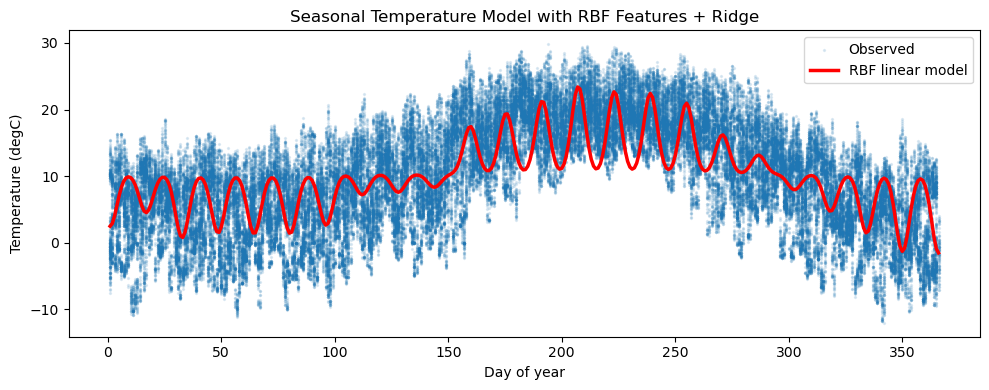

In [4]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Use cleaned data from cell 1
# temp_df has columns: LST_DATETIME, AIR_TEMPERATURE
season_df = temp_df.copy()

# Feature = day-of-year (captures seasonal cycle), target = air temperature
doy = season_df["LST_DATETIME"].dt.dayofyear.to_numpy().reshape(-1, 1)
y = season_df["AIR_TEMPERATURE"].to_numpy()

# Optional downsample to keep computation fast in notebook
max_points = 120000
if len(doy) > max_points:
    idx = np.linspace(0, len(doy) - 1, max_points).astype(int)
    doy = doy[idx]
    y = y[idx]

# RBF centers across the calendar year
centers = np.linspace(1, 366, 24).reshape(-1, 1)
sigma = 18.0   # spread of each basis function in "day" units
alpha = 1.0    # ridge regularization strength

# RBF feature expansion + linear parameter model
x = rbf_kernel(doy, centers, gamma=1.0 / sigma)
regr = Ridge(alpha=alpha, fit_intercept=True)
regr.fit(x, y)
y_hat = regr.predict(x)

print("Shapes:")
print("  doy:", doy.shape)
print("  x (RBF features):", x.shape)
print("  y:", y.shape)
print("\nModel quality on sampled data:")
print(f"  R^2 = {r2_score(y, y_hat):.4f}")
print(f"  MAE = {mean_absolute_error(y, y_hat):.4f} degC")

# Smooth seasonal curve across one year
grid = np.linspace(1, 366, 366).reshape(-1, 1)
grid_x = rbf_kernel(grid, centers, gamma=1.0 / sigma)
grid_y = regr.predict(grid_x)

plt.figure(figsize=(10, 4))
plt.scatter(doy, y, s=2, alpha=0.12, label="Observed")
plt.plot(grid, grid_y, color="red", linewidth=2.5, label="RBF linear model")
plt.xlabel("Day of year")
plt.ylabel("Temperature (degC)")
plt.title("Seasonal Temperature Model with RBF Features + Ridge")
plt.legend()
plt.tight_layout()
plt.show()



In [6]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Performance metric: RMSE (lower is better)
# We'll tune on validation data and report final test performance.
season_df = temp_df.copy()
season_df["year"] = season_df["LST_DATETIME"].dt.year
season_df["doy"] = season_df["LST_DATETIME"].dt.dayofyear

# Time-based split avoids leakage across time
train_df = season_df[season_df["year"] <= 2014]
val_df = season_df[season_df["year"] == 2015]
test_df = season_df[season_df["year"] == 2016]

# Downsample train for speed while preserving coverage
max_train = 150000
if len(train_df) > max_train:
    train_df = train_df.iloc[np.linspace(0, len(train_df)-1, max_train).astype(int)]

X_train_raw = train_df[["doy"]].to_numpy()
y_train = train_df["AIR_TEMPERATURE"].to_numpy()
X_val_raw = val_df[["doy"]].to_numpy()
y_val = val_df["AIR_TEMPERATURE"].to_numpy()
X_test_raw = test_df[["doy"]].to_numpy()
y_test = test_df["AIR_TEMPERATURE"].to_numpy()

best = None
for n_centers in [12, 24, 36, 52]:
    centers = np.linspace(1, 366, n_centers).reshape(-1, 1)
    for sigma in [8.0, 12.0, 18.0, 25.0, 35.0]:
        for alpha in [0.01, 0.1, 1.0, 10.0]:
            Phi_train = rbf_kernel(X_train_raw, centers, gamma=1.0 / sigma)
            Phi_val = rbf_kernel(X_val_raw, centers, gamma=1.0 / sigma)

            model = Ridge(alpha=alpha, fit_intercept=True)
            model.fit(Phi_train, y_train)

            pred_train = model.predict(Phi_train)
            pred_val = model.predict(Phi_val)

            rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
            rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))

            if best is None or rmse_val < best["rmse_val"]:
                best = {
                    "n_centers": n_centers,
                    "sigma": sigma,
                    "alpha": alpha,
                    "rmse_train": rmse_train,
                    "rmse_val": rmse_val,
                }

# Train best model and evaluate on held-out test year
centers = np.linspace(1, 366, best["n_centers"]).reshape(-1, 1)
Phi_train = rbf_kernel(X_train_raw, centers, gamma=1.0 / best["sigma"])
Phi_test = rbf_kernel(X_test_raw, centers, gamma=1.0 / best["sigma"])

best_model = Ridge(alpha=best["alpha"], fit_intercept=True)
best_model.fit(Phi_train, y_train)
pred_test = best_model.predict(Phi_test)

rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test = mean_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)

print("Best validation config:")
print(best)
print("\nHeld-out 2016 test performance:")
print(f"RMSE = {rmse_test:.4f} degC")
print(f"MAE  = {mae_test:.4f} degC")
print(f"R^2  = {r2_test:.4f}")




Best validation config:
{'n_centers': 36, 'sigma': 35.0, 'alpha': 10.0, 'rmse_train': 5.011904600081315, 'rmse_val': 5.434168893365809}

Held-out 2016 test performance:
RMSE = 5.2037 degC
MAE  = 4.3120 degC
R^2  = 0.5525
